# Modeling Spread From Historical Data

# 1 - Loading the data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import yfinance as yf
import mplfinance as mpf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from scipy.stats import laplace, cauchy

In [2]:
df = pd.read_csv('data/EURUSD_Ticks_30.12.2024-30.12.2024.csv', parse_dates=['Gmt time'], dayfirst=True)
df = df.rename(columns={"Gmt time" : "Date"})
df

,Date,Ask,Bid,AskVolume,BidVolume
0,2024-12-30 00:00:01.473,1.04298,1.04297,0.90,0.90
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25
...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45


# 2 - Historical Spread Distribution

In [3]:
df['Spread'] = df['Ask'] - df['Bid']
df

,Date,Ask,Bid,AskVolume,BidVolume,Spread
0,2024-12-30 00:00:01.473,1.04298,1.04297,0.90,0.90,0.00001
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80,0.00001
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90,0.00001
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90,0.00004
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25,0.00003
...,...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74,0.00005
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90,0.00004
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90,0.00003
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45,0.00003


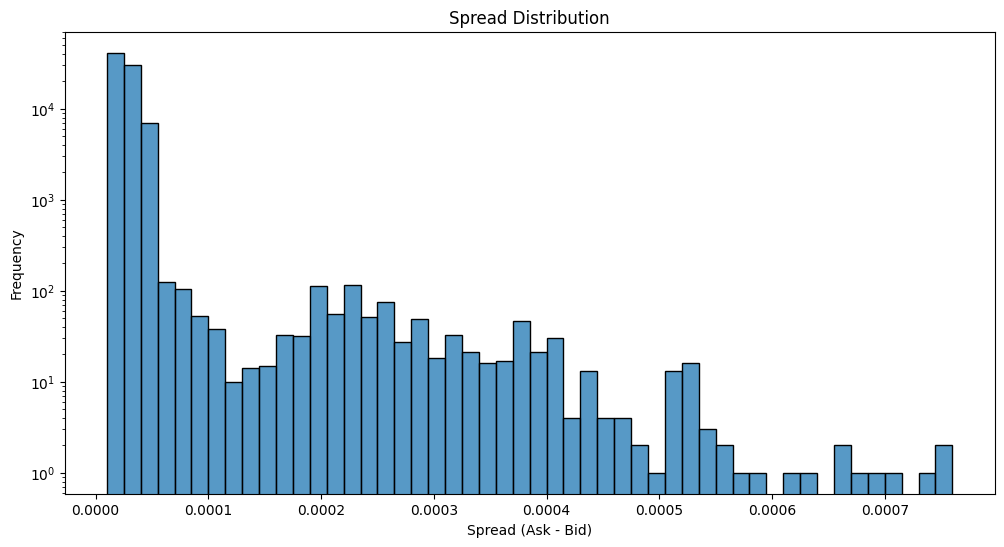

In [4]:
plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50)
plt.yscale('log')
plt.title('Spread Distribution')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency')
plt.show()

# 3 - Trying to fit the Spread in a distributiom

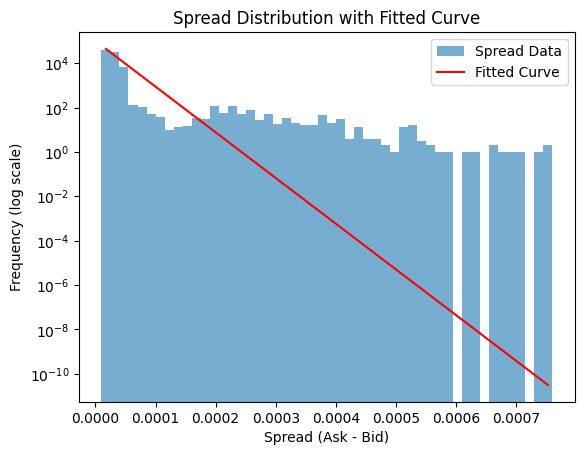

Fitted Curve: y = 100654.29 * exp(-47429.51 * x)


In [5]:
def Spread_fit(x, a, b):
    return a * np.exp(-b * x)

spread_data = df['Spread'].to_numpy()
bin_heights, bin_borders, _ = plt.hist(spread_data, bins=50, log=True, label='Spread Data', alpha=0.6)

bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2
params, covariance = curve_fit(Spread_fit, bin_centers, bin_heights, p0=[1, 1])

# params: An array of the optimal values for the parameters that minimize the residuals beteween the 
# provided function (spread_fit) and the data (bin_centers, bin_heights).
# covariance: The estimated covariance of params. The diagonals provide the variance of the parameter estimates

plt.plot(bin_centers, Spread_fit(bin_centers, *params), 'r-', label='Fitted Curve')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.title('Spread Distribution with Fitted Curve')
plt.legend()
plt.show()

spread_fit_equation = f"Fitted Curve: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x)"
print(spread_fit_equation)

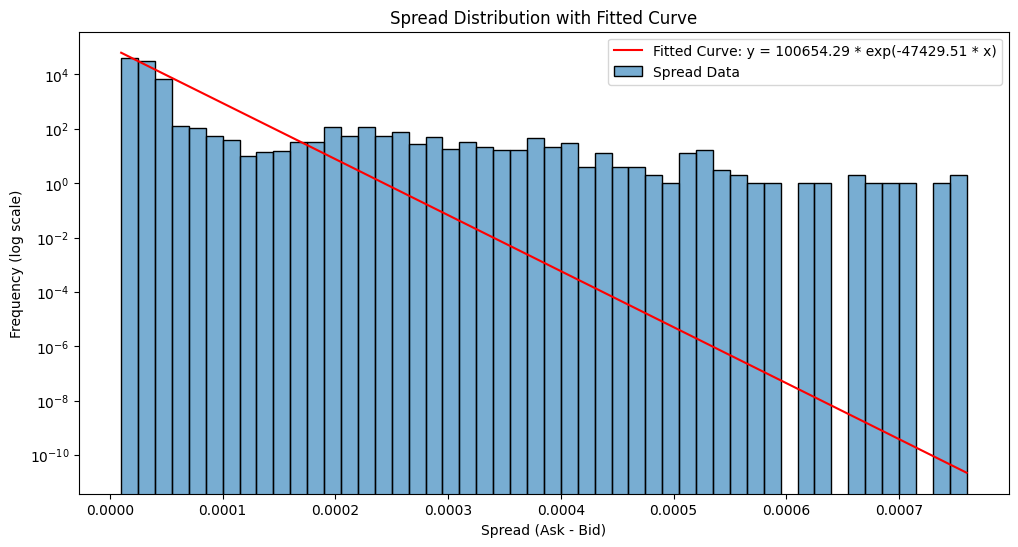

In [6]:
x = np.linspace(df['Spread'].min(), df['Spread'].max(), 100)
y = spread_fit_equation

plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50, label='Spread Data', alpha=0.6)
plt.yscale('log')
plt.plot(x, Spread_fit(x, *params), 'r-', label=y)
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.title('Spread Distribution with Fitted Curve')
plt.legend()
plt.show()

# 4 - Generating Spread with the Von Neumann (Pure Numerical Approach)

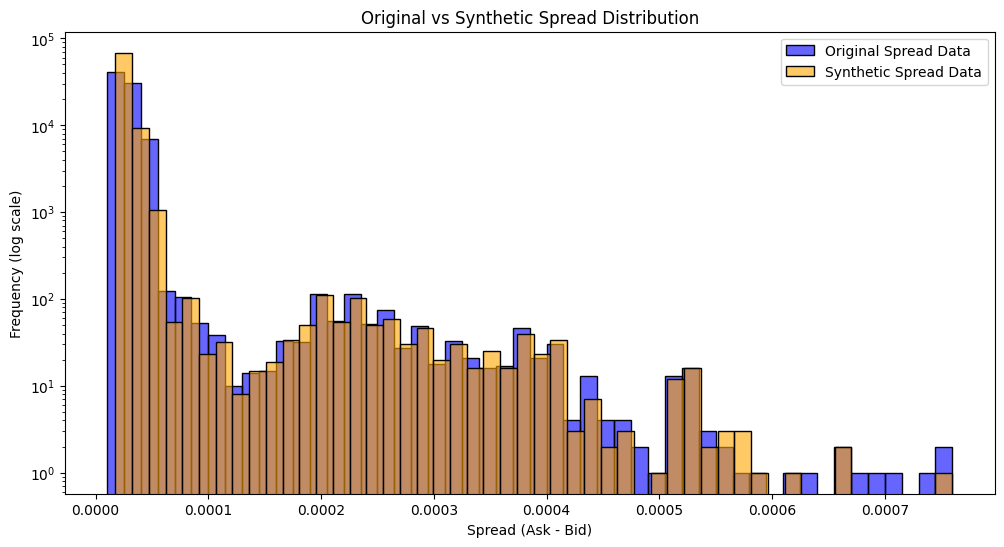

In [7]:
# Calculate the histogram of the spread data
hist_counts, bin_edges = np.histogram(df['Spread'], bins=100, density=True)

# Calculate the cumulative distribution function (CDF)
cdf = np.cumsum(hist_counts) * np.diff(bin_edges)

# Function to perform inverse transform sampling
def inverse_transform_sampling(cdf, bin_edges, num_samples):
    random_values = np.random.rand(num_samples)
    sampled_spreads = np.interp(random_values, cdf, bin_edges[1:])
    return sampled_spreads

# Generate synthetic spread data
num_samples = len(df)
synthetic_spreads = inverse_transform_sampling(cdf, bin_edges, num_samples)

# Plot the original and synthetic spread distributions
plt.figure(figsize=(12,6))
sns.histplot(df['Spread'], bins=50, label='Original Spread Data', color='blue', alpha=0.6)
sns.histplot(synthetic_spreads, bins=50, label='Synthetic Spread Data', color='orange', alpha=0.6)
plt.yscale('log')
plt.xlabel('Spread (Ask - Bid)')
plt.ylabel('Frequency (log scale)')
plt.title('Original vs Synthetic Spread Distribution')
plt.legend()
plt.show()

# 5 - Plotting the Cumulative for Clarity

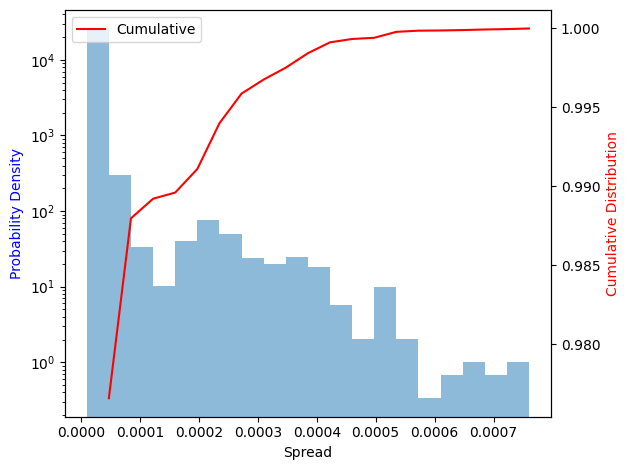

In [ ]:
num_bins = 20

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot the histogram
ax1.hist(df["Spread"], bins=num_bins, density=True, log=True, alpha=0.5, label='Actual Spread')

# Compute and plot the cumulative distribution
cumulative = np.cumsum(np.histogram(df["Spread"], bins=num_bins, density=True)[0])
cumulative = cumulative / cumulative[-1]  # Normalize the cumulative distribution
ax2.plot(np.histogram(df["Spread"], bins=num_bins)[1][1:], cumulative, 'r-', label='Cumulative')

ax1.set_xlabel('Spread')
ax1.set_ylabel('Probability Density', color='b')
ax2.set_ylabel('Cumulative Distribution', color='r')

fig.tight_layout()  # Prevents the labels from getting cut off
plt.legend(loc='best')
plt.show()

# Modeling Synthenic Price Data From Historical Data

# 1 - Loading the data

In [11]:
df = pd.read_csv('data/EURUSD_Ticks_30.12.2024-30.12.2024.csv', parse_dates=['Gmt time'], dayfirst=True)
df = df.rename(columns={"Gmt time" : "Date"})
df

,Date,Ask,Bid,AskVolume,BidVolume
0,2024-12-30 00:00:01.473,1.04298,1.04297,0.90,0.90
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25
...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45


# 2 - Computing Price Variablility in a histogram

In [12]:
df['Ask_Diff'] = df['Ask'].diff()
df.dropna(inplace=True)
df

,Date,Ask,Bid,AskVolume,BidVolume,Ask_Diff
1,2024-12-30 00:00:01.579,1.04299,1.04298,2.25,1.80,0.00001
2,2024-12-30 00:00:01.682,1.04300,1.04299,2.25,0.90,0.00001
3,2024-12-30 00:00:01.785,1.04303,1.04299,0.90,0.90,0.00003
4,2024-12-30 00:00:05.383,1.04302,1.04299,0.90,2.25,-0.00001
5,2024-12-30 00:00:05.488,1.04302,1.04298,0.90,2.79,0.00000
...,...,...,...,...,...,...
79744,2024-12-30 23:59:44.482,1.04062,1.04057,0.90,7.74,0.00000
79745,2024-12-30 23:59:55.733,1.04062,1.04058,0.90,0.90,0.00000
79746,2024-12-30 23:59:57.849,1.04061,1.04058,0.90,0.90,-0.00001
79747,2024-12-30 23:59:58.005,1.04060,1.04057,0.90,0.45,-0.00001


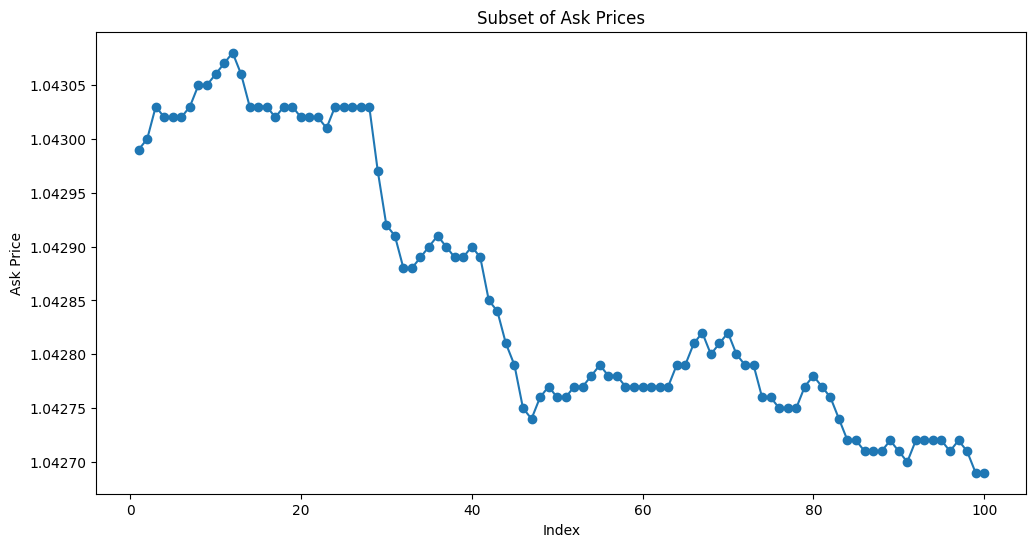

In [13]:
start_index = 0
num_rows = 100

df_subset = df['Ask'].iloc[start_index:start_index + num_rows]

plt.figure(figsize=(12,6))
plt.plot(df_subset.index, df_subset.values, marker='o')
plt.title('Subset of Ask Prices')
plt.xlabel('Index')
plt.ylabel('Ask Price')
plt.show()

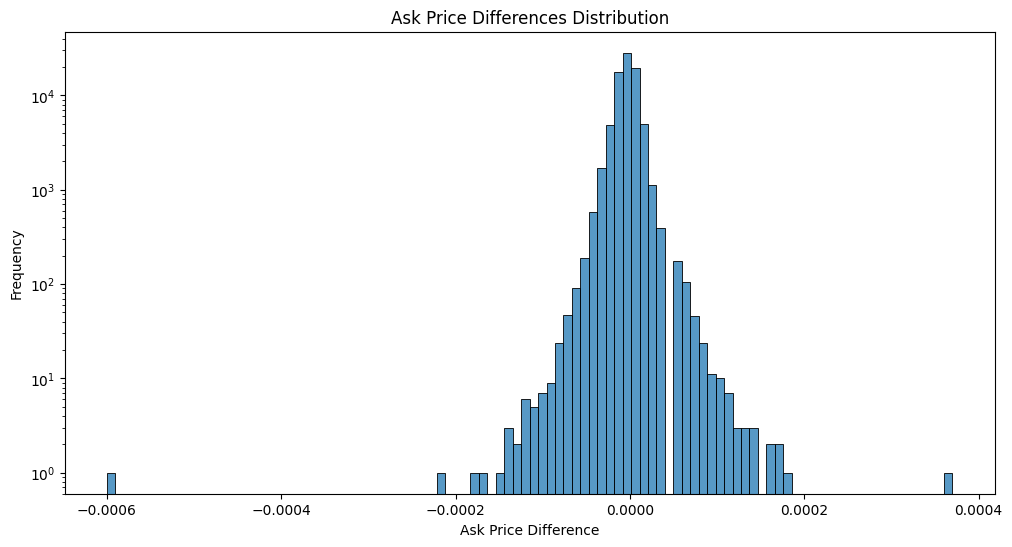

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(df['Ask_Diff'], bins=100, log=True)
plt.title('Ask Price Differences Distribution')
plt.xlabel('Ask Price Difference')
plt.ylabel('Frequency')
plt.show()

# 3 - Fitting Variability into Laplace distribution

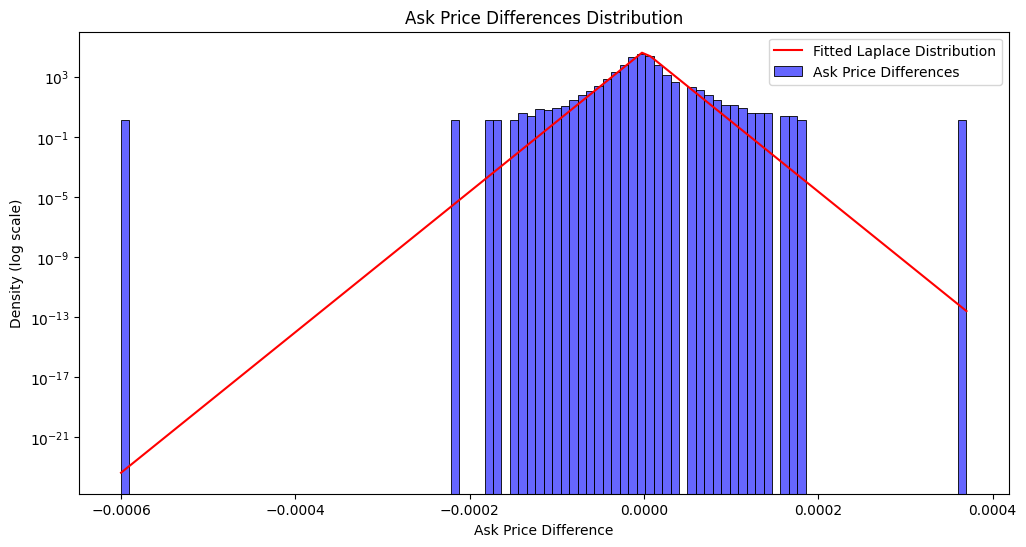

In [21]:
# Plot the histogram of Ask_Diff
plt.figure(figsize=(12,6))
sns.histplot(df['Ask_Diff'], bins=100, stat='density', label='Ask Price Differences', color='blue', alpha=0.6)
plt.yscale('log')
plt.title('Ask Price Differences Distribution')
plt.xlabel('Ask Price Difference')
plt.ylabel('Density (log scale)')

# Fit Laplace distribution to the Ask_Diff data
loc, scale = laplace.fit(df['Ask_Diff'])
x = np.linspace(df['Ask_Diff'].min(), df['Ask_Diff'].max(), 100)
pdf_fitted = laplace.pdf(x, loc, scale)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Laplace Distribution')
plt.legend()
plt.show()

# 4 - Fitting Variability into Cauchy distribution

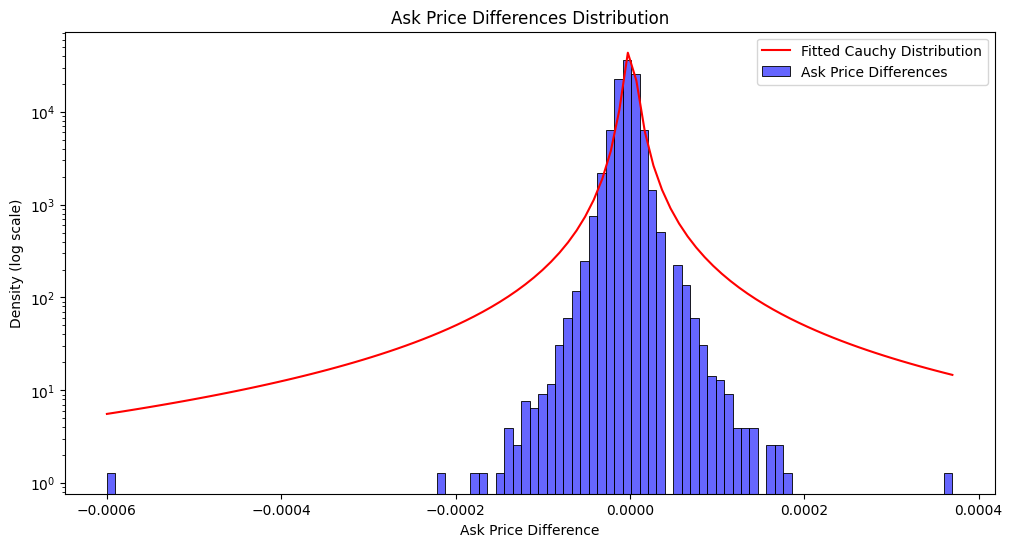

In [23]:
# Plot the histogram of Ask_Diff
plt.figure(figsize=(12,6))
sns.histplot(df['Ask_Diff'], bins=100, stat='density', label='Ask Price Differences', color='blue', alpha=0.6)
plt.yscale('log')
plt.title('Ask Price Differences Distribution')
plt.xlabel('Ask Price Difference')
plt.ylabel('Density (log scale)')

# Fit Laplace distribution to the Ask_Diff data
loc, scale = cauchy.fit(df['Ask_Diff'])
x = np.linspace(df['Ask_Diff'].min(), df['Ask_Diff'].max(), 100)
pdf_fitted = cauchy.pdf(x, loc, scale)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Cauchy Distribution')
plt.legend()
plt.show()

# 5 - Fitting in a Modified/Custom Cauchy distribution

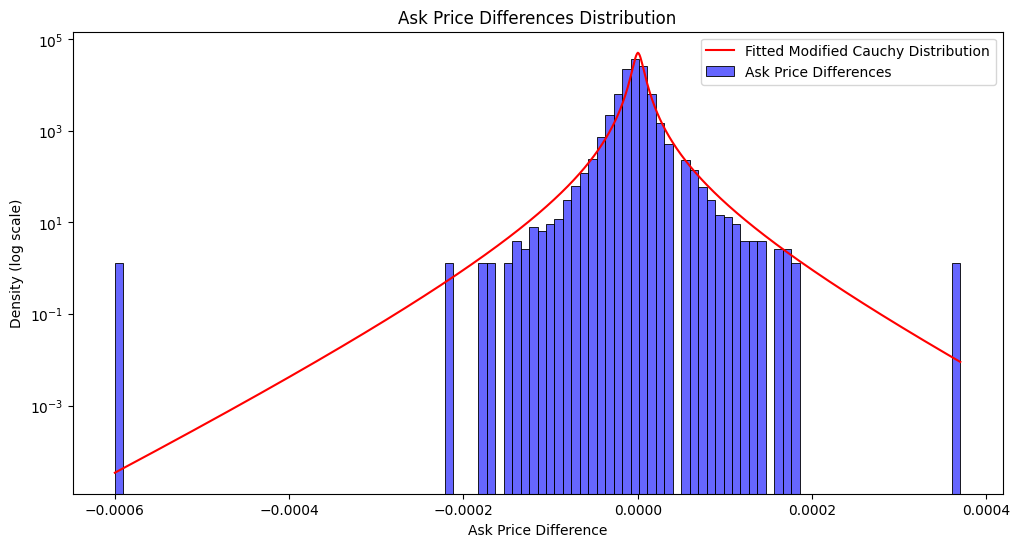

In [25]:
# Plot the histogram of Ask_Diff
plt.figure(figsize=(12,6))
sns.histplot(df['Ask_Diff'], bins=100, stat='density', label='Ask Price Differences', color='blue', alpha=0.6)
plt.yscale('log')
plt.title('Ask Price Differences Distribution')
plt.xlabel('Ask Price Difference')
plt.ylabel('Density (log scale)')

# Fit Laplace distribution to the Ask_Diff data
loc, scale = cauchy.fit(df['Ask_Diff'])
x = np.linspace(df['Ask_Diff'].min(), df['Ask_Diff'].max(), 1000)

def modified_cauchy_pdf(x, loc, scale):
    return cauchy.pdf(x, loc, scale) * np.exp(-20000 * np.abs(x))

pdf_fitted = modified_cauchy_pdf(x, loc, scale)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Modified Cauchy Distribution')
plt.legend()
plt.show()

# 6 - Generate Random Variable with the Modified Cauchy Distribution

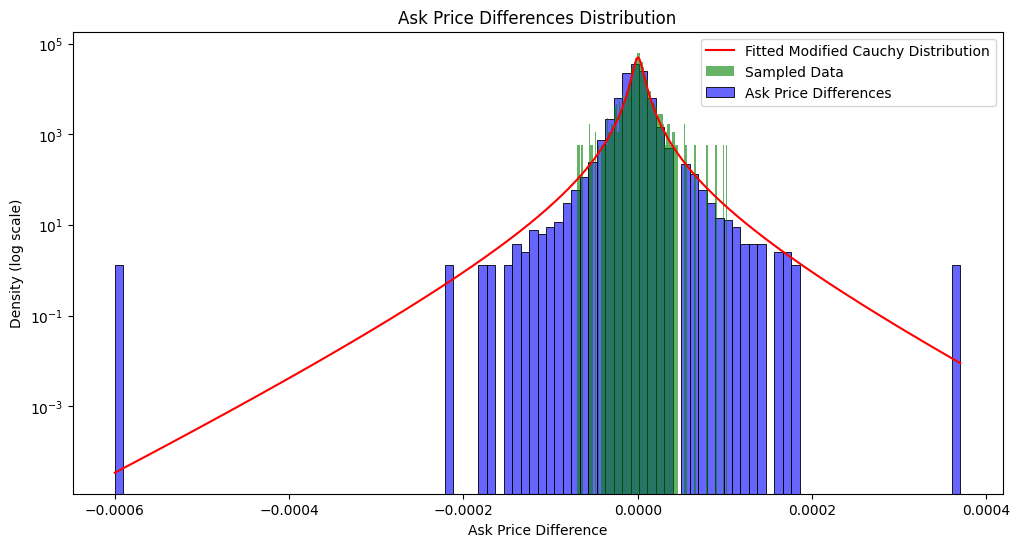

In [37]:
# Plot the histogram of Ask_Diff
plt.figure(figsize=(12,6))
sns.histplot(df['Ask_Diff'], bins=100, stat='density', label='Ask Price Differences', color='blue', alpha=0.6)
plt.yscale('log')
plt.title('Ask Price Differences Distribution')
plt.xlabel('Ask Price Difference')
plt.ylabel('Density (log scale)')

# Fit Laplace distribution to the Ask_Diff data
loc, scale = cauchy.fit(df['Ask_Diff'])
x = np.linspace(df['Ask_Diff'].min(), df['Ask_Diff'].max(), 1000)

def modified_cauchy_pdf(x, loc, scale):
    return cauchy.pdf(x, loc, scale) * np.exp(-20000 * np.abs(x))

def sample_modified_cauchy(loc, scale, size):
    samples = []
    while len(samples) < size:
        sample = cauchy.rvs(loc, scale)
        acceptance_prob = np.exp(-20000 * np.abs(sample))
        if np.random.rand() < acceptance_prob:
            samples.append(sample)
    return np.array(samples)

pdf_fitted = modified_cauchy_pdf(x, loc, scale)
random_samples = sample_modified_cauchy(loc, scale, size=1000)

plt.plot(x, pdf_fitted, 'r-', label='Fitted Modified Cauchy Distribution')
plt.hist(random_samples, bins=100, density=True, alpha=0.6, label='Sampled Data', color='green')
plt.legend()
plt.show()

# 7 - Generating Synthetic Data based on Modified Cauchy Distribution

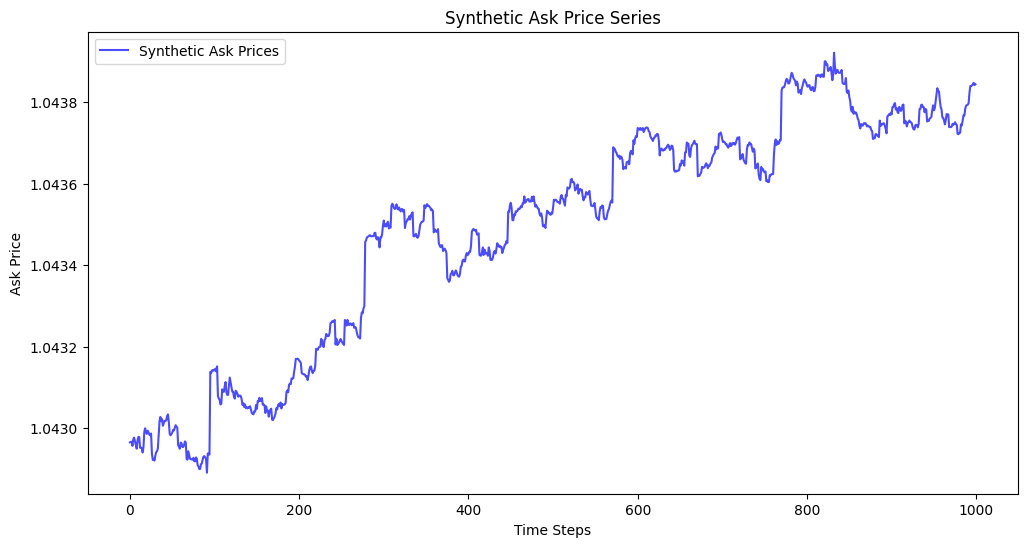

In [44]:
# 1 - Define the sampling function
def sample_modified_cauchy(loc, scale, size):
    samples = []
    while len(samples) < size:
        u = np.random.rand()
        sample = loc + scale * np.tan(np.pi * (u - 0.5))  # Inverse CDF sampling for Cauchy
        acceptance_prob = np.exp(-20000 * np.abs(sample))
        if np.random.rand() < acceptance_prob:
            samples.append(sample)
    return np.array(samples)

# 2 - Simulate synthetic price differences
steps = 1000
start_price = df['Ask'].iloc[0]

loc, scale = cauchy.fit(df['Ask_Diff'])
synthetic_diffs = sample_modified_cauchy(loc, scale, size=steps)
np.clip(synthetic_diffs, -0.002, 0.002, out=synthetic_diffs)

synthetic_prices = start_price * np.exp(np.cumsum(synthetic_diffs))

# 3 - Plot the synthetic price series
plt.figure(figsize=(12,6))
plt.plot(synthetic_prices, label='Synthetic Ask Prices', color='blue', alpha=0.7)
plt.title('Synthetic Ask Price Series')
plt.xlabel('Time Steps')
plt.ylabel('Ask Price')
plt.legend()
plt.show()

# 8 - Adding Spread: Generating Spread (Von Neumann Numeric Approach)

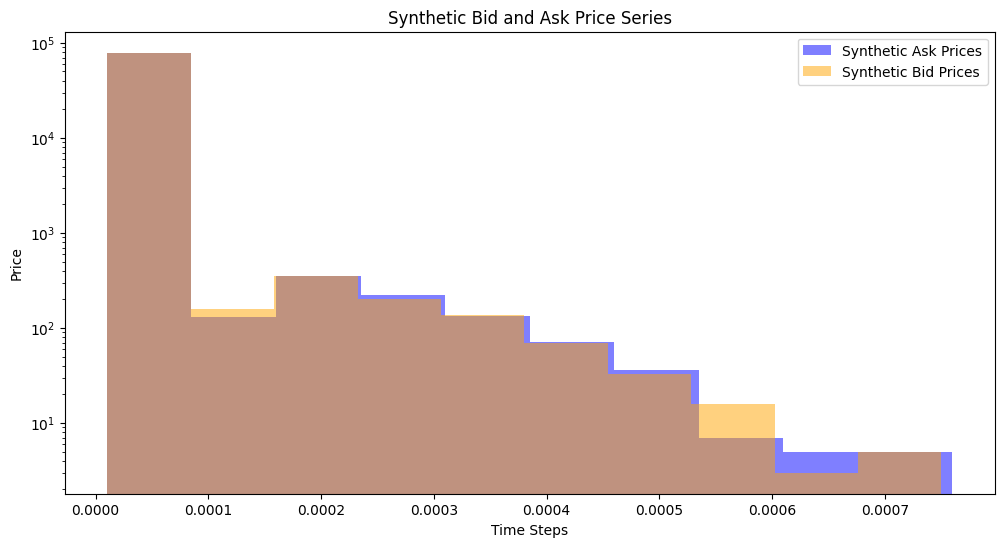

In [49]:
df['Spread'] = df['Ask'] - df['Bid']

# Calculate the histogram of the spread data
hist_counts, bin_edges = np.histogram(df['Spread'], bins='auto', density=True)

# Calculate the cumulative distribution function (CDF)
cdf = np.cumsum(hist_counts) * np.diff(bin_edges)

# Function to perform inverse transform sampling
def inverse_transform_sampling(cdf, bin_edges, num_samples):
    random_values = np.random.rand(num_samples)
    sampled_spreads = np.interp(random_values, cdf, bin_edges[1:])
    return sampled_spreads

# Generate synthetic spread data
num_samples = len(df)
random_samples = inverse_transform_sampling(cdf, bin_edges, num_samples)

# 5 - Plot the synthetic price and spread series
plt.figure(figsize=(12,6))
plt.hist(df['Spread'], label='Synthetic Ask Prices', color='blue', alpha=0.5, log=True)
plt.hist(random_samples, label='Synthetic Bid Prices', color='orange', alpha=0.5, log=True)
plt.title('Synthetic Bid and Ask Price Series')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# 9 - Generating Synthetic Prices Based on Historical Data

In [52]:
random_samples = inverse_transform_sampling(cdf, bin_edges, steps)

synthetic_prices_df = pd.DataFrame({
    'Ask': synthetic_prices,
    'Bid': synthetic_prices - random_samples,
    'Spread': random_samples
})

In [53]:
synthetic_prices_df

,Ask,Bid,Spread
0,1.042965,1.042955,0.00001
1,1.042967,1.042947,0.00002
2,1.042967,1.042947,0.00002
3,1.042957,1.042937,0.00002
4,1.042973,1.042933,0.00004
...,...,...,...
995,1.043841,1.043821,0.00002
996,1.043843,1.043823,0.00002
997,1.043847,1.043837,0.00001
998,1.043841,1.043821,0.00002


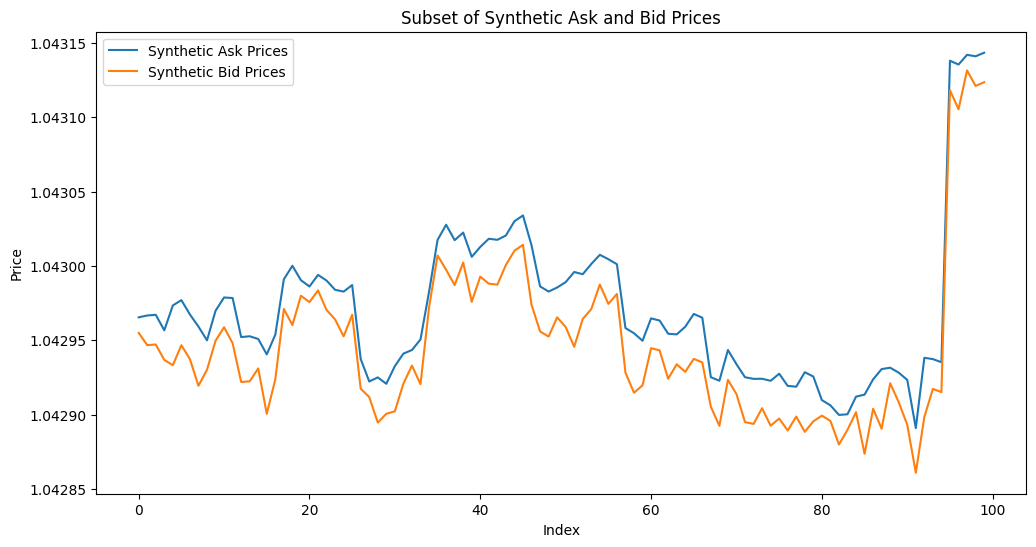

In [55]:
start_index = 0
num_rows = 100

plt.figure(figsize=(12,6))
plt.plot(synthetic_prices_df['Ask'].iloc[start_index:start_index + num_rows].values, label='Synthetic Ask Prices')
plt.plot(synthetic_prices_df['Bid'].iloc[start_index:start_index + num_rows].values, label='Synthetic Bid Prices')
plt.title('Subset of Synthetic Ask and Bid Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# 10 - Aggregate and plot into candles

In [76]:
group_size = 30 # Number of ticks per candle

# Create a group identifier for each candle
synthetic_prices_df['group'] = synthetic_prices_df.index // group_size

# Aggregate into OHLC candles
candles = synthetic_prices_df.groupby('group').agg({
    'Ask': ['first', 'max', 'min', 'last']
}).droplevel(0, axis=1)

candles.columns = ['Open', 'High', 'Low', 'Close']

# Optional: Reset index if needed
candles = candles.reset_index(drop=True)

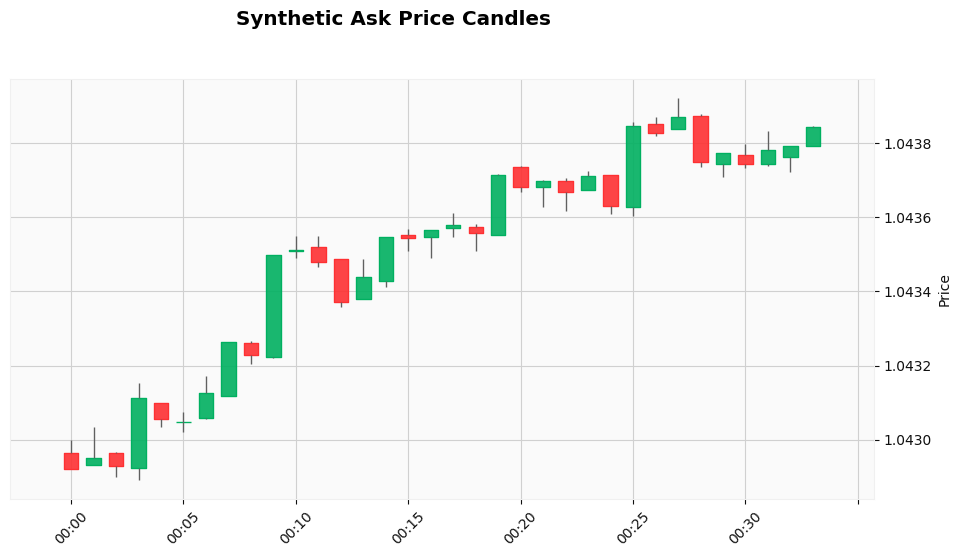

In [77]:
# Create a DatetimeIndex for the candles dataframe
candles.index = pd.date_range(start='2024-12-30', periods=len(candles), freq='1min')

mpf.plot(candles[0:100], type='candle', style='yahoo', title='Synthetic Ask Price Candles', ylabel='Price', figsize=(12,6))